In [2]:
import open3d as o3d
import numpy as np 


pcd = o3d.io.read_point_cloud("cloud1.pcd")

# origin of point cloud 
centroid = np.mean(np.asarray(pcd.points), axis=0)

# downsampling 
downsampled_pcd = pcd.voxel_down_sample(voxel_size=0.1)

# alinging point cloud and origin as same 
downsampled_pcd.translate(-centroid)

# Create coordinate axes
axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3, origin=[0, 0, 0])

# converting point cloud points to numpy 2D array
downsampled_points = np.asarray(downsampled_pcd.points)

# threshold
threshold = 0.02

# Keep only points where Z is approximately 0 (within ±epsilon)
filtered_points = downsampled_points[np.abs(downsampled_points[:, 2]) < threshold]

# Convert back to Open3D point cloud
filtered_pcd = o3d.geometry.PointCloud()
filtered_pcd.points = o3d.utility.Vector3dVector(filtered_points)

# Color the filtered point cloud red
#filtered_pcd.paint_uniform_color([1, 0, 0])

# Visualize the filtered point cloud with axes
o3d.visualization.draw_geometries([filtered_pcd, axis])


No of inlier points: 48
No. of total filtered points: 156
No. of points in max density region: 13


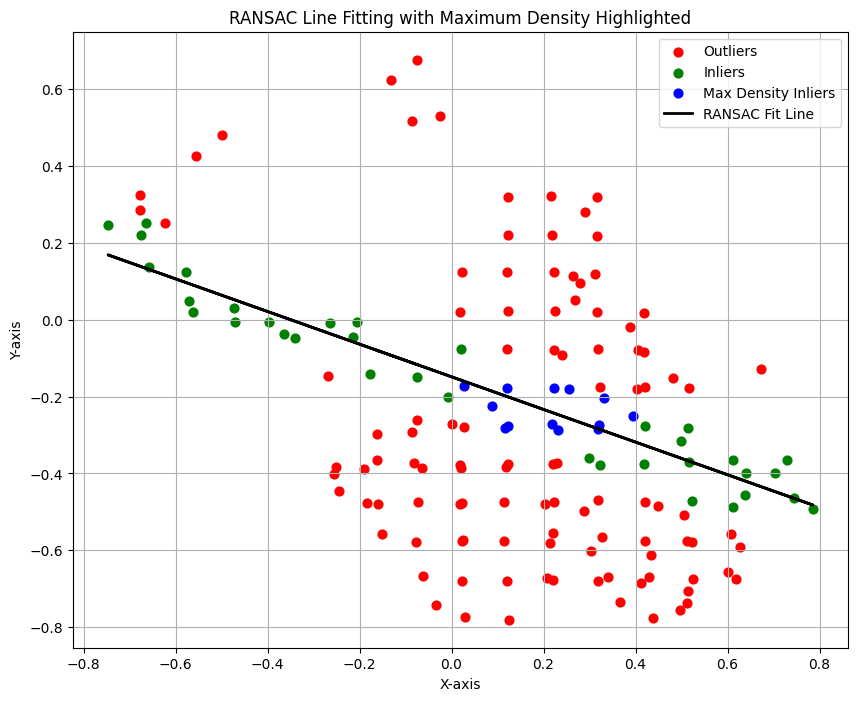

In [60]:
import numpy as np 
import open3d as o3d 
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor


x_point = filtered_points[:, 0]
y_point = filtered_points[:, 1]

x_point = np.array(x_point).reshape(-1, 1)
y_point = np.array(y_point).reshape(-1, 1)


ransac = RANSACRegressor(
    residual_threshold=0.01,
    max_trials=100,
    min_samples=30,
    stop_n_inliers=70,
    stop_score=0.95,
    loss="squared_error",
    random_state=None
)

ransac.fit(x_point, y_point)

inlier_mask = ransac.inlier_mask_  
outlier_mask = ~inlier_mask 

line_X = np.array(x_point).reshape(-1, 1)
line_y = ransac.predict(line_X)


x_inliers = x_point[inlier_mask].flatten()
y_inliers = y_point[inlier_mask].flatten()


bins = 4  # more points
H, xedges, yedges = np.histogram2d(x_inliers, y_inliers, bins=bins)

max_bin_idx = np.unravel_index(np.argmax(H), H.shape)

x_min, x_max = xedges[max_bin_idx[0]], xedges[max_bin_idx[0] + 1]
y_min, y_max = yedges[max_bin_idx[1]], yedges[max_bin_idx[1] + 1]

max_density_mask = (x_inliers >= x_min) & (x_inliers <= x_max) & (y_inliers >= y_min) & (y_inliers <= y_max)

plt.figure(figsize=(10, 8))

plt.scatter(x_point[outlier_mask], y_point[outlier_mask], color="red", label="Outliers", s=40)

plt.scatter(x_inliers[~max_density_mask], y_inliers[~max_density_mask], color="green", label="Inliers", s=40)

plt.scatter(x_inliers[max_density_mask], y_inliers[max_density_mask], color="blue", label="Max Density Inliers", s=40)

plt.plot(line_X, line_y, color="black", linewidth=2, label="RANSAC Fit Line")

# display
print("No of inlier points:", len(x_point[inlier_mask]))
print("No. of total filtered points:", len(x_point[outlier_mask]) + len(x_point[inlier_mask]))
print("No. of points in max density region:", np.sum(max_density_mask))

plt.title("RANSAC Line Fitting with Maximum Density Highlighted")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.legend()
plt.grid(True)
plt.show()


